This is another one of those "reminder about lesser known RDKit features" posts.

The RDKit has had the ability to condense common functional groups to short-hand abbreviations for a few years. This is primarily intended as a way to simplify the drawings of molecules. This can be quite useful, particularly when preparing figures for publication.

Here's a simple illustration. The molecule:

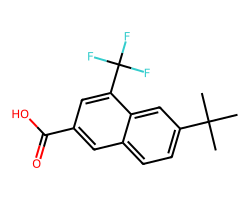

can be drawn with abbreviations as:
dsas
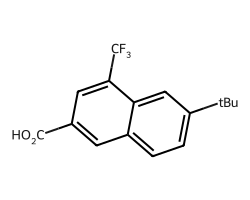

In this post I'll provide a short overview of the functionality. There's also a [cookbook entry](https://www.rdkit.org/docs/Cookbook.html#with-abbreviations) on the topic.

In [1]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 250,200
from rdkit.Chem import rdAbbreviations

import rdkit
rdkit.__version__

'2023.09.4'

# Abbreviation basics

Let's start with the example used in the introduction to this post:

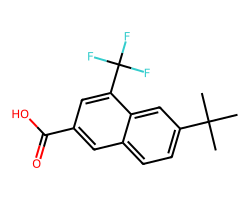

In [2]:
m = Chem.MolFromSmiles('FC(F)(F)c1cc(C(=O)O)cc2ccc(C(C)(C)C)cc21')
m

We can get a new molecule which uses abbreviations with the function `rdAbbreviations.CondenseMolAbbreviations()`:

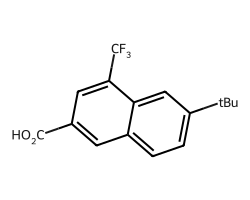

In [3]:
# CondenseMolAbbreviations requires a set of abbreviations to be used. Here we pick the defaults:
abbrevs = rdAbbreviations.GetDefaultAbbreviations()

# Now use them:
amol = rdAbbreviations.CondenseMolAbbreviations(m,abbrevs)
amol

This isn't a cosmetic transformation, the output molecule has less atoms:

In [4]:
m.GetNumAtoms(),amol.GetNumAtoms()

(21, 13)

The result molecule has dummy atoms where the abbreviations are drawn:

In [5]:
Chem.MolToSmiles(amol)

'*c1cc(*)c2cc(*)ccc2c1'

And the abbreviations themselves can be preserved with CXSMILES:

In [6]:
Chem.MolToCXSmiles(amol)

'*c1cc(*)c2cc(*)ccc2c1 |$CO2H;;;;CF3;;;;tBu;;;;$|'

This allows us to round-trip abbreviations through CXSMILES:

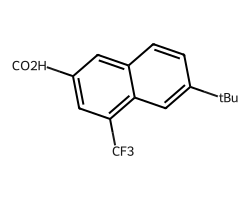

In [7]:
Chem.MolFromSmiles('*c1cc(*)c2cc(*)ccc2c1 |$CO2H;;;;CF3;;;;tBu;;;;$|')

There is a threshold on the maximum percentage of atoms in the molecule which can be replaced by abbreviations. The default value for this is 0.4, so the CF3 group here is not replaced:

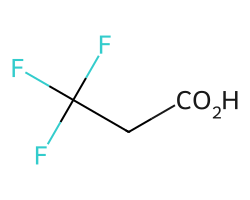

In [8]:
m = Chem.MolFromSmiles('FC(F)(F)CC(=O)O')
amol = rdAbbreviations.CondenseMolAbbreviations(m,abbrevs)
amol

But we can change that threshold with the `maxCoverage` argument:

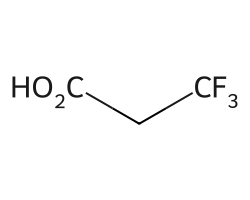

In [9]:
amol = rdAbbreviations.CondenseMolAbbreviations(m,abbrevs,maxCoverage=0.8)
amol

The code will never abbreviate groups which are bonded directly to each other, no matter how high `maxCoverage` is set:

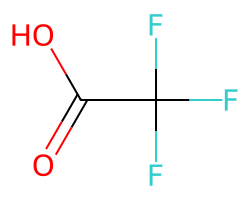

In [10]:
m = Chem.MolFromSmiles('FC(F)(F)C(=O)O')
amol = rdAbbreviations.CondenseMolAbbreviations(m,abbrevs,maxCoverage=1)
amol

Here's the default list of abbreviations

In [11]:
for abbrev in abbrevs:
    print(abbrev.label,Chem.MolToSmiles(abbrev.mol))

CO2Et *C(=O)OCC
COOEt *C(=O)OCC
OiBu *OCC(C)C
nDec *CCCCCCCCCC
nNon *CCCCCCCCC
nOct *CCCCCCCC
nHept *CCCCCCC
nHex *CCCCCC
nPent *CCCCC
iPent *C(C)CCC
tBu *C(C)(C)C
iBu *C(C)CC
nBu *CCCC
iPr *C(C)C
nPr *CCC
Et *CC
NCF3 *NC(F)(F)F
CF3 *C(F)(F)F
CCl3 *C(Cl)(Cl)Cl
CN *C#N
NC *[N+]#[C-]
N(OH)CH3 *N(C)[OH]
NO2 *[N+](=O)[O-]
NO *N=O
SO3H *S(=O)(=O)[OH]
CO2H *C(=O)[OH]
COOH *C(=O)[OH]
OEt *OCC
OAc *OC(C)=O
NHAc *NC(C)=O
Ac *C(C)=O
CHO *C=O
NMe *NC
SMe *SC
OMe *OC
CO2- *C(=O)[O-]
COO- *C(=O)[O-]


# Adding your own abbreviations

You can extend the list of default abbreviations with your own additions:

In [12]:
abbrevs = rdAbbreviations.GetDefaultAbbreviations()
nabbrevs = rdAbbreviations.ParseAbbreviations('''Ph3C C(c1ccccc1)(c1ccccc1)c1ccccc1 CPh3
TosO OS(=O)(=O)c1ccc(C)cc1 OTos''')
# make sure our new abbreviations are at the front of the list so that they 
# match before anything else. We could also put them at the end so that 
# the default abbreviations have priority
for abbrev in abbrevs:
     nabbrevs.append(abbrev)
abbrevs = nabbrevs

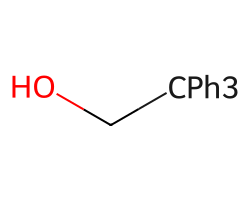

In [13]:
rdAbbreviations.CondenseMolAbbreviations(Chem.MolFromSmiles('OCC(c1ccccc1)(c1ccccc1)c1ccccc1'),abbrevs,maxCoverage=1.0)


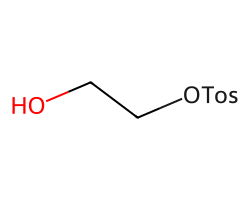

In [14]:
rdAbbreviations.CondenseMolAbbreviations(Chem.MolFromSmiles('OCCOS(=O)(=O)c1ccc(C)cc1'),abbrevs,maxCoverage=1.0)


# Replacing the abbreviations

We can also completely replace the list of abbreviations with our own definitions.

Here's a github discussion on the topic: https://github.com/rdkit/rdkit/discussions/3677


In [15]:
import re

# data from: https://github.com/metamolecular/osra/blob/master/dict/superatom.txt
abbrev_defns='''# Translations of superatom labels to SMILES.
# First atom of SMILES string should be the one connected to the rest of
# the molecule.
# Empty lines and lines starting with # are ignored.
# Also check spelling.txt to see that the superatom label
# is correctly spelled.

Me	 C
MeO      OC
MeS      SC
MeN      NC
CF       CF
CF3      C(F)(F)F
CN       C#N
F3CN     NC(F)(F)F
Ph       c1ccccc1
NO       N=O
NO2      N(=O)=O
N(OH)CH3 N(O)C
SO3H     S(=O)(=O)O
COOH     C(=O)O
nBu      CCCC
EtO      OCC
OiBu     OCC(C)C
iPr      CCC
tBu      C(C)(C)C
Ac       C(=O)C
AcO      OC(=O)C
NHAc     NC(=O)C
OR       O*
#BzO      OCc1ccccc1
BzO OC(=O)C1=CC=CC=C1
THPO     O[C@@H]1OCCCC1

CHO    C=O
NOH    NO 

# Added  release 1.3.0
CO2Et C(=O)OCC
CO2Me C(=O)OC
MeO2S S(=O)(=O)C
NMe2  N(C)C
CO2R  C(=O)O*
ZNH   NC(=O)OCC1=CC=CC=C1
HOCH2 CO
H2NCH2 CN
Et CC
BnO OCC1=CC=CC=C1
AmNH NCCCCC
AmO OCCCCC
AmO2C C(=O)OCCCCC
AmS SCCCCC
BnNH NCC1=CC=CC=C1
BnO2C C(=O)OCC1=CC=CC=C1
Bu3Sn [Sn](CCCC)(CCCC)CCCC
BuNH    NCCCC
BuO     OCCCC
BuO2C   C(=O)OCCCC
BuS     SCCCC
CBr3    C(Br)(Br)Br
CbzNH   NC(=O)OCC1=CC=CC=C1
CCl3    C(Cl)(Cl)Cl
ClSO2	S(=O)(=O)Cl
COBr    C(=O)Br
COBu    C(=O)CCCC
COCF3   C(=O)C(F)(F)F
COCl    C(=O)Cl
COCO    C(=O)C=O
COEt    C(=O)CC
COF     C(=O)F
COMe    C(=O)C
OCOMe OC(=O)C
CONH2   C(=O)N
CONHEt  C(=O)NCC
CONHMe  C(=O)NC
COSH    C(=O)S
Et2N    N(CC)CC
Et3N    N(CC)(CC)CC
EtNH    NCC
H2NSO2  S(=O)(N)=O
HONH    ON
Me2N    N(C)C
NCO     N=C=O
NCS     N=C=S
NHAm    NCCCCC
NHBn    NCC1=CC=CC=C1
NHBu    NCCCC
NHEt    NCC
NHOH    NO
NHPr    NCCC
NO      N=O
POEt2   P(OCC)OCC
POEt3   P(OCC)(OCC)OCC
POOEt2  P(=O)(OCC)OCC
PrNH    CCCN
SEt     SCC

BOC C(=O)OC(C)(C)C
MsO OS(=O)(=O)C
OTos OS(=O)(=O)c1ccc(C)cc1
Tos S(=O)(=O)c1ccc(C)cc1
C8H CCCCCCCC
C6H CCCCCC
CH2CH3 CC
N(CH2CH3)2 N(CC)CC
N(CH2CH2CH3)2 N(CCC)CCC
C(CH3)3 C(C)(C)C
COCH3 C(=O)C
CH(CH3)2 C(C)C
OCF3 OC(F)(F)F
OCCl3 OC(Cl)(Cl)Cl
OCF2H OC(F)F
SO2Me S(=O)(=O)C
OCH2CO2H OCC(=O)O
OCH2CO2Et OCC(=O)OCC
BOC2N N(C(=O)OC(C)(C)C)C(=O)OC(C)(C)C
BOCHN NC(=O)OC(C)(C)C
NHCbz NC(=O)OCc1ccccc1
OCH2CF3 OCC(F)(F)F
NHSO2BU NS(=O)(=O)CCCC
NHSO2Me NS(=O)(=O)C
MeO2SO OS(=O)(=O)C
NHCOOEt NC(=O)OCC
NHCH3 NC
H4NOOC C(=O)ON
C3H7 CCC
C2H5 CC
NHNH2 NN
OCH2CH2OH OCCO
OCH2CHOHCH2OH OCC(O)CO
OCH2CHOHCH2NH OCC(O)CN
NHNHCOCH3 NNC(=O)C
NHNHCOCF3 NNC(=O)C(F)(F)F
NHCOCF3 NC(=O)C(F)(F)F
CO2CysPr C(=O)ON[C@H](CS)C(=O)CCC
HOH2C CO
H3CHN NC
H3CO2C C(=O)OC
CF3CH2 CC(F)(F)F
OBOC OC(=O)OC(C)(C)C
Bn2N N(Cc1ccccc1)Cc1ccccc1
F5S S(F)(F)(F)(F)F
PPh2 P(c1ccccc1)c1ccccc1
PPh3 P(c1ccccc1)(c1ccccc1)c1ccccc1
OCH2Ph OCc1ccccc1
CH2OMe COC
PMBN NCc1ccc(OC)cc1
SO2 S(=O)=O
NH3Cl NCl
CF2CF3 C(F)(F)C(F)(F)F
CF2CF2H C(F)(F)C(F)(F)
Bn Cc1ccccc1
OCH2Ph OCc1ccccc1
COOCH2Ph C(=O)OCc1ccccc1
Ph3CO OC(c1ccccc1)(c1ccccc1)c1ccccc1
Ph3C C(c1ccccc1)(c1ccccc1)c1ccccc1
Me2NO2S S(C)(C)N(=O)=O
SO3Na S(=O)(=O)(=O)[Na]
OSO2Ph OS(=O)(=O)c1ccccc1
(CH2)5Br CCCCCBr
OPh Oc1ccccc1
SPh Sc1ccccc1
NHPh Nc1ccccc1

CONEt2 C(=O)N(CC)CC
CONMe2 C(=O)N(C)C
EtO2CHN NC(=O)OCC
H4NO3S S(=O)(=O)ON
TMS [Si](C)(C)(C)
COCOOCH2CH3 C(=O)C(=O)OCC
OCH2CN OCC#N
#
#  these are useful for expanding superatoms, but not helpful for collapsing them
# Xx [*]
# X  [*]
# Y [*]
# Z [*]
# R [*]
# R1 [*]
# R2 [*]
# R3 [*]
# R4 [*]
# R5 [*]
# R6 [*]
# R7 [*]
# R8 [*]
# R9 [*]
# R10 [*]
# Y2 [*]
#D [*]
'''
# preprocess the definitions:
defns = []
for l in abbrev_defns.split('\n'):
    if not l or l[0]=='#':
        continue
    defn = re.sub(r'[ ]+','\t',l)
    sma = defn.split('\t')[1]
    # use the length of the SMARTS as a crude size sort
    defns.append((len(sma),l))
abbrev_defns = '\n'.join([x[1] for x in sorted(defns,reverse=True)])
print(abbrev_defns)
abbrevs = rdAbbreviations.ParseAbbreviations(abbrev_defns)

BOC2N N(C(=O)OC(C)(C)C)C(=O)OC(C)(C)C
Ph3CO OC(c1ccccc1)(c1ccccc1)c1ccccc1
Ph3C C(c1ccccc1)(c1ccccc1)c1ccccc1
PPh3 P(c1ccccc1)(c1ccccc1)c1ccccc1
CO2CysPr C(=O)ON[C@H](CS)C(=O)CCC
OTos OS(=O)(=O)c1ccc(C)cc1
Bn2N N(Cc1ccccc1)Cc1ccccc1
Tos S(=O)(=O)c1ccc(C)cc1
Bu3Sn [Sn](CCCC)(CCCC)CCCC
ZNH   NC(=O)OCC1=CC=CC=C1
PPh2 P(c1ccccc1)c1ccccc1
CbzNH   NC(=O)OCC1=CC=CC=C1
OSO2Ph OS(=O)(=O)c1ccccc1
BnO2C C(=O)OCC1=CC=CC=C1
SO3Na S(=O)(=O)(=O)[Na]
BzO OC(=O)C1=CC=CC=C1
NHCbz NC(=O)OCc1ccccc1
OBOC OC(=O)OC(C)(C)C
NHNHCOCF3 NNC(=O)C(F)(F)F
COOCH2Ph C(=O)OCc1ccccc1
CF2CF3 C(F)(F)C(F)(F)F
BOCHN NC(=O)OC(C)(C)C
THPO     O[C@@H]1OCCCC1
POEt3   P(OCC)(OCC)OCC
PMBN NCc1ccc(OC)cc1
NHSO2BU NS(=O)(=O)CCCC
NHCOCF3 NC(=O)C(F)(F)F
Me2NO2S S(C)(C)N(=O)=O
F5S S(F)(F)(F)(F)F
CF2CF2H C(F)(F)C(F)(F)
BOC C(=O)OC(C)(C)C
TMS [Si](C)(C)(C)
POOEt2  P(=O)(OCC)OCC
NHBn    NCC1=CC=CC=C1
COCOOCH2CH3 C(=O)C(=O)OCC
COCF3   C(=O)C(F)(F)F
BnO OCC1=CC=CC=C1
BnNH NCC1=CC=CC=C1
OCCl3 OC(Cl)(Cl)Cl
CONEt2 C(=O)N(CC)CC
NHSO2Me NS(=O)(=

We can then use those abbreviations the same way the defaults are used:

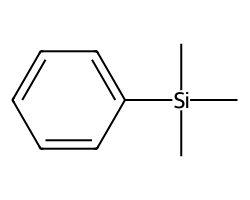

In [16]:
m = Chem.MolFromSmiles('c1ccccc1[Si](C)(C)C')
m

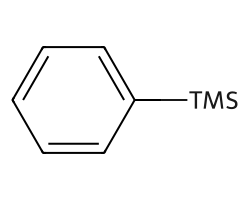

In [17]:
rdAbbreviations.CondenseMolAbbreviations(m,abbrevs,maxCoverage=0.6)

# Using linkers

Abbreviations are used for terminal groups: a functional group which only has one connection to the rest of the molecule. `CondenseMolAbbreviations()` can also identify and replace linkers - sets of atoms with connections at both ends.

This is a bit trickier, and there are far fewer default linkers, but the functionality can still be useful.

Start by looking at the linkers that are available by default:

In [18]:
linkers =rdAbbreviations.GetDefaultLinkers()
for entry in linkers:
    print(entry.label,Chem.MolToSmiles(entry.mol))

PEG6 *OCCOCCOCCOCCOCCOCC
PEG5 *OCCOCCOCCOCCOCC
PEG4 *OCCOCCOCCOCC
PEG3 *OCCOCCOCC
Dec *CCCCCCCCCC
Non *CCCCCCCCC
Oct *CCCCCCCC
Hept *CCCCCCC


We apply linkers the same way we did abbreviations:

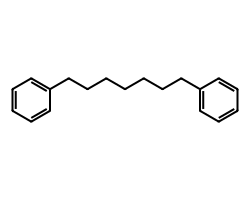

In [19]:
m = Chem.MolFromSmiles('c1ccccc1CCCCCCCc1ccccc1')
m

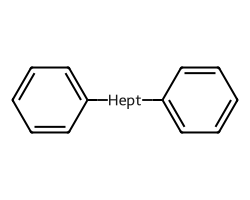

In [20]:
amol = rdAbbreviations.CondenseMolAbbreviations(m,linkers,maxCoverage=0.8)
amol

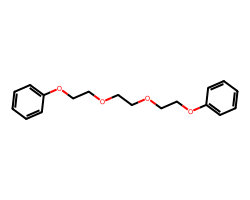

In [21]:
m = Chem.MolFromSmiles('c1ccccc1OCCOCCOCCOc1ccccc1')
m

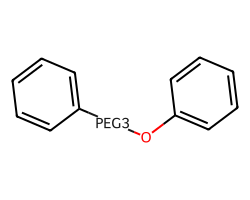

In [22]:
amol = rdAbbreviations.CondenseMolAbbreviations(m,linkers,maxCoverage=0.8)
amol

One can argue about whether or not that last O should also be matched by the PEG3 linker. I'm happy to hear opinions about that.